In [49]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [50]:
project_dir = Path.cwd().parent
input_dir = Path.cwd().parent / 'input'
output_dir = Path.cwd().parent / 'output' / "mediation_analysis"
output_dir.mkdir(parents=True, exist_ok=True)

In [51]:
scores_df = pd.read_csv(project_dir / 'output' / 'pls' / 'scores_correlation.csv', index_col=0).drop_duplicates()
ukb_clinical_df = pd.read_csv(input_dir / 'clinical_data_ukb.csv', index_col=0).drop_duplicates()
hchs_clinical_df = pd.read_csv(input_dir / 'clinical_data_hchs.csv', index_col=0).drop_duplicates()

In [52]:
y_ukb = pd.read_csv(input_dir/"y_ukb.csv", index_col=0)
y_ukb["cohort"] = 1
y_hchs = pd.read_csv(input_dir/"y_hchs.csv", index_col=0)
y_hchs["cohort"] = 0

# Cognitive scores

In [5]:
cognitive_scores_hchs = [
 'cognition_vocabulary_b_test',
 'cognition_word_list_recall', 
 'cognition_animal_naming_test',
 'cognition_clock_drawing_test',
 "cognition_tmt_a",
 "cognition_tmt_b", 
]

cognitive_scores_ukb = [
    'cognition_fluid_intelligence_score',
    'cognition_matrix_pattern_completion__correct_puzzles',
    'cognition_numeric_memory_test_max__digits',
    'cognition_paired_associate_learning__correct_pairs',
    'cognition_prospective_memory_result',
    'cognition_reaction_time_log',
    'cognition_symbol_digit_substitution__correct_matches',
    'cognition_tower_rearranging_test__correct_puzzles',
    "cognition_tmt_a",
    "cognition_tmt_b", 
    ]



In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ukb_clinical_df[["cognition_tmt_b", "cognition_tmt_a"]] = scaler.fit_transform(ukb_clinical_df[[ 'cognition_tmt_b__time_log','cognition_tmt_a__time_log',]])
hchs_clinical_df[["cognition_tmt_b", "cognition_tmt_a"]] = scaler.fit_transform(hchs_clinical_df[['cognition_tmt_b_log', 'cognition_tmt_a_log']])

In [8]:
y_combined = pd.concat([y_ukb, y_hchs], axis=0)

In [10]:
covariates = ['base_age', 'base_sex', "base_education_isced", "cohort"]

scores_df = scores_df.join(ukb_clinical_df[cognitive_scores_ukb], how='left').join(y_combined[covariates], how="left").join(hchs_clinical_df.drop(["cognition_tmt_b", "cognition_tmt_a"], axis=1), how='left')
statistics_df = scores_df.combine_first(hchs_clinical_df[["cognition_tmt_b", "cognition_tmt_a"]])

In [11]:
statistics_df = statistics_df.drop_duplicates()

In [13]:
imaging_score = 'Imaging score'
pls_scores = ['Clinical score', imaging_score]
cognitive_scores = list(set(cognitive_scores_ukb + cognitive_scores_hchs))# ["attention_executive_function_avg", "memory_avg", "information_processing_speed_avg", "reasoning_avg"]


In [30]:
cognitive_scores = [
    "cognition_reaction_time_log",
    'cognition_symbol_digit_substitution__correct_matches',
    'cognition_tower_rearranging_test__correct_puzzles',
    'cognition_tmt_a',
    'cognition_tmt_b',

    'cognition_numeric_memory_test_max__digits',
    'cognition_paired_associate_learning__correct_pairs',
    'cognition_prospective_memory_result',
    'cognition_word_list_recall',

    'cognition_fluid_intelligence_score',
    'cognition_matrix_pattern_completion__correct_puzzles',
    'cognition_vocabulary_b_test',

    'cognition_animal_naming_test',
    'cognition_clock_drawing_test',
]

In [ ]:
import pingouin as pg
from scipy.stats import zscore

r_df = pd.DataFrame()
p_df = pd.DataFrame()
p_interaction_df = pd.DataFrame()
coef_interaction_df = pd.DataFrame()

mediation_coef_Xmed_df = pd.DataFrame()
mediation_coef_medY_df = pd.DataFrame()
mediation_coef_total_df = pd.DataFrame()
mediation_coef_direct_df = pd.DataFrame()
mediation_coef_indirect_df = pd.DataFrame()

mediation_p_medY_df = pd.DataFrame() 
mediation_p_Xmed_df = pd.DataFrame() 
mediation_p_total_df = pd.DataFrame() 
mediation_p_direct_df = pd.DataFrame() 
mediation_p_indirect_df = pd.DataFrame() 

for col in cognitive_scores + ['Clinical score', imaging_score] + covariates:
    statistics_df[f"{col}_z"] = zscore(statistics_df[col], nan_policy="omit")

for y in cognitive_scores:

    x = f"Clinical score_z"

    r = pg.corr(statistics_df[x], statistics_df[y], method="pearson").loc["pearson", "r"]

    # Mediation analysis
    mediation_result = pg.mediation_analysis(data=statistics_df, x=f"{x}", m=f"{imaging_score}_z", y=f"{y}_z", covar=covariates, alpha=0.05, seed=1, n_boot=5000)
    
    r_df.loc[x, y] = r

    mediation_coef_Xmed_df.loc[x, y] = mediation_result.at[0, 'coef']
    mediation_coef_medY_df.loc[x, y] = mediation_result.at[1, 'coef']
    mediation_coef_total_df.loc[x, y] = mediation_result.at[2, 'coef']
    mediation_coef_direct_df.loc[x, y] = mediation_result.at[3, 'coef']
    mediation_coef_indirect_df.loc[x, y] = mediation_result.at[4, 'coef']

    mediation_p_Xmed_df.loc[x, y] = mediation_result.at[0, 'pval']
    mediation_p_medY_df.loc[x, y] = mediation_result.at[1, 'pval']
    mediation_p_total_df.loc[x, y] = mediation_result.at[2, 'pval']
    mediation_p_direct_df.loc[x, y] = mediation_result.at[3, 'pval']
    mediation_p_indirect_df.loc[x, y] = mediation_result.at[4, 'pval']

#p_fdr_df = pd.DataFrame(pg.multicomp(p_df.values, method="fdr_bh")[1], index=p_df.index, columns=p_df.columns)
mediation_p_Xmed_fdr_df = pd.DataFrame(pg.multicomp(mediation_p_Xmed_df.values, method="fdr_bh")[1].reshape(-1,14), index=mediation_p_Xmed_df.index, columns=mediation_p_Xmed_df.columns)
mediation_p_medY_fdr_df = pd.DataFrame(pg.multicomp(mediation_p_medY_df.values, method="fdr_bh")[1].reshape(-1,14), index=mediation_p_medY_df.index, columns=mediation_p_medY_df.columns)
mediation_p_total_fdr_df = pd.DataFrame(pg.multicomp(mediation_p_total_df.values, method="fdr_bh")[1].reshape(-1,14), index=mediation_p_total_df.index, columns=mediation_p_total_df.columns)
mediation_p_direct_fdr_df = pd.DataFrame(pg.multicomp(mediation_p_direct_df.values, method="fdr_bh")[1].reshape(-1,14), index=mediation_p_direct_df.index, columns=mediation_p_direct_df.columns)
mediation_p_indirect_fdr_df = pd.DataFrame(pg.multicomp(mediation_p_indirect_df.values, method="fdr_bh")[1].reshape(-1,14), index=mediation_p_indirect_df.index, columns=mediation_p_indirect_df.columns)

In [16]:
cognitive_cols_styling_dict = {
    "cognition_fluid_intelligence_score": "Fluid Intelligence Test",
    "cognition_matrix_pattern_completion__correct_puzzles": "Matrix Pattern Completion Test",
    "cognition_numeric_memory_test_max__digits": "Numeric Memory Test",
    "cognition_paired_associate_learning__correct_pairs": "Paired Associate Learning Test",
    "cognition_prospective_memory_result": "Prospective Memory Test",
    "cognition_reaction_time_log": "Reaction time",
    "cognition_symbol_digit_substitution__correct_matches": "Symbol Digit Substitution Test",
    "cognition_tower_rearranging_test__correct_puzzles": "Tower Rearranging Test",
    "cognition_tmt_a": "TMT-A",
    "cognition_tmt_b": "TMT-B",
    "cognition_vocabulary_b_test": "Vocabulary Intelligence Test",
    "cognition_word_list_recall": "Word List Recall",
    "cognition_animal_naming_test": "Animal Naming Test",
    "cognition_clock_drawing_test": "Clock Drawing Test",
}



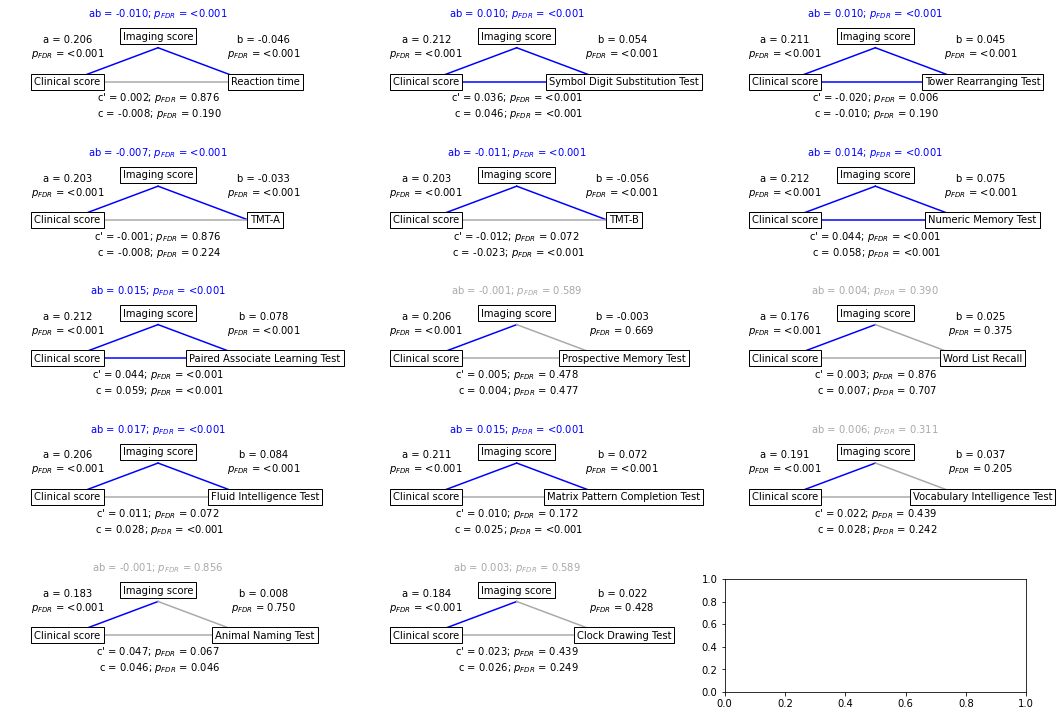

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

grid = [
    (0,0),(0,1),(0,2),
    (1,0),(1,1),(1,2),
    (2,0),(2,1),(2,2),
    (3,0),(3,1),(3,2),
    (4,0),(4,1),(4,2),
]

# Determine the number of unique X and Y variables
n_x =  2 #len(["Clinical score_z"])
n_y = int(len(cognitive_scores) / 2)

# Set up the facet grid
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, x in enumerate(["Clinical score_z"]):
    for j, y in enumerate(cognitive_scores):
        idx1,idx2 = grid[j]
        ax = axes[idx1,idx2]

        x_styled = "Clinical score"
        y_styled = cognitive_cols_styling_dict[y]

        # Extract mediation coefficients for the current x and y
        a_path = mediation_coef_Xmed_df.loc[x, y]
        b_path = mediation_coef_medY_df.loc[x, y]
        c_prime_path = mediation_coef_direct_df.loc[x, y]
        ab_path = mediation_coef_indirect_df.loc[x, y]
        c_path = mediation_coef_total_df.loc[x, y]  # Added for total effect

        # Extract p-values for the paths
        p_a = mediation_p_Xmed_fdr_df.loc[x, y]
        p_b = mediation_p_medY_fdr_df.loc[x, y]
        p_c_prime = mediation_p_direct_fdr_df.loc[x, y]
        p_ab = mediation_p_indirect_fdr_df.loc[x, y]
        p_c = mediation_p_total_fdr_df.loc[x, y]  # Added for total effect p-value

        # Determine colors based on significance
        color_a = 'blue' if p_a < 0.05 else 'darkgray'
        color_b = 'blue' if p_b < 0.05 else 'darkgray'
        color_c_prime = 'blue' if p_c_prime < 0.05 else 'darkgray'
        color_ab = 'blue' if p_ab < 0.05 and p_a < 0.05 and p_b < 0.05 else 'darkgray'
        color_c = 'blue' if p_c < 0.05 else 'darkgray'  # Added for total effect color

        # Format p-values for display
        formatted_p_values = {}
        for path, p in zip(['p_a', 'p_b', 'p_c_prime', 'p_ab', 'p_c'], [p_a, p_b, p_c_prime, p_ab, p_c]):
                if p > 0.001 and f"{p:.3f}" == "0.050":
                    formatted_p_values[path] = f"{p:.4f}"
                elif p > 0.001:
                    formatted_p_values[path] = f"{p:.3f}"
                else:
                    formatted_p_values[path] = "<0.001"


        # Draw paths a, b, c' and c with lines instead of arrows
        ax.plot([0.2, 0.5], [0.5, 0.8], color=color_a)  # a path
        ax.plot([0.5, 0.8], [0.8, 0.5], color=color_b)  # b path
        ax.plot([0.2, 0.9], [0.5, 0.5], color=color_c_prime)  # c' path

        # Annotate paths with coefficients and p-values
        ax.text(0.2, 0.8, f'a = {a_path:.3f}\n$p_{{FDR}}$ = {formatted_p_values["p_a"]}', va='center', ha='center', fontsize=10)
        ax.text(0.85, 0.8, f'b = {b_path:.3f}\n$p_{{FDR}}$ = {formatted_p_values["p_b"]}', va='center', ha='center', fontsize=10)
        ax.text(0.5, 0.15, f"c' = {c_prime_path:.3f}; $p_{{FDR}}$ = {formatted_p_values['p_c_prime']}\n c = {c_path:.3f}; $p_{{FDR}}$ = {formatted_p_values['p_c']}", va='bottom', ha='center', fontsize=10)
        ax.text(0.5, 1.1, f'ab = {ab_path:.3f}; $p_{{FDR}}$ = {formatted_p_values["p_ab"]}', va='center', ha='center', fontsize=10, color=color_ab)  # Indirect effect annotation

        # Add boxes for Independent Variable, Mediator Variable, and Dependent Variable
        ax.text(0.2, 0.5, x_styled, va='center', ha='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
        ax.text(0.5, 0.9, "Imaging score", va='center', ha='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
        ax.text(0.855, 0.5, y_styled, va='center', ha='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')

axes[4, 2].set_visible(False)

# Improve layout and display the plot
plt.tight_layout()
plt.savefig(output_dir/"mediation_analysis.png", dpi=300)
plt.show()